In [560]:
import json # library to handle JSON files
import numpy as np
import pandas as pd 
import requests
from bs4 import BeautifulSoup


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge osmnx --yes 

print('Libraries imported.')

Solving environment: / ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt

Libraries imported.


In [561]:
CLIENT_ID = 'VBYXTOANJ0HBNZMORHZYGT5GMLVYC5EUX3RVSGILPPJUAKSV' # your Foursquare ID
CLIENT_SECRET = 'WEURAKXYHLQCCMOJVHUU54CIVWMCXP0TJG0A34OT4F4353PY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: VBYXTOANJ0HBNZMORHZYGT5GMLVYC5EUX3RVSGILPPJUAKSV
CLIENT_SECRET:WEURAKXYHLQCCMOJVHUU54CIVWMCXP0TJG0A34OT4F4353PY


# 1. Load data

In [562]:
### Original CSV at the date of 10th, May
geo_cas_communautaire= pd.read_csv("Covid19_SN/zone_c_confirmesGeo.csv") 
geo_cas_communautaire.head()

,departement,borough,neighborhood,cas,lat,lon
0,Pikine,Niayes,Keur Massar,2,14.786388,-17.320696
1,Rufisque,Sangalkam,Diamniadio,2,14.720230,-17.184827
2,Rufisque,Rufisque,Rufisque,11,14.715560,-17.279684
3,Pikine,Dagoudane,Pikine,14,14.755262,-17.404480
4,Pikine,Thiaroye,Thiaroye Gare,1,14.757339,-17.378268


In [563]:
### Load updated data at the current date
updated= pd.read_csv('https://raw.githubusercontent.com/senegalouvert/COVID-19/master/data/zone_c_confirmesGeo.csv')
updated

,district,cas,lat,lon
0,Louga,1,15.617326,-16.255818
1,Saint-Louis,2,16.020035,-16.493319
2,Ziguinchor,1,12.559898,-16.309203
3,Touba,55,14.867642,-15.917822
4,Mbour,5,14.416536,-16.987211
5,Thiès,10,14.788645,-16.962288
6,Keur Massar,2,14.786388,-17.320696
7,Diamniadio,2,14.720230,-17.184827
8,Rufisque,11,14.715560,-17.279684
9,Pikine,15,14.755262,-17.404480


In [564]:
#Add the regions columns to the Updated file
# correct Sangalkham coordinates in files
address = 'Sangalkam, SN'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_sang = location.latitude
longitude_sang = location.longitude
print('The geographical coordinate of Dakar are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Dakar are 14.693425, -17.447938.


In [565]:
updated.loc[updated['district']=='Sangalkham',['lon']]= longitude_sang


In [566]:
#Add the regions column to the Updated file
geo_region=[]
for index, row in updated.iterrows():
    location = geolocator.reverse("{}, {}".format(row['lat'], row['lon']))
    geo_region.append((location.raw)['address']['region'])
print(len(geo_region))
updated['region']= geo_region
updated.drop(updated[updated['region']!='Dakar' ].index,inplace=True)
updated.drop(['region'],axis=1,inplace=True)
updated.head()

51


,district,cas,lat,lon
6,Keur Massar,2,14.786388,-17.320696
7,Diamniadio,2,14.720230,-17.184827
8,Rufisque,11,14.715560,-17.279684
9,Pikine,15,14.755262,-17.404480
10,Thiaroye Gare,1,14.757339,-17.378268


In [567]:
new_cases= updated.merge(geo_cas_communautaire, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
new_cases


,district,cas,lat,lon,departement,borough,neighborhood,_merge
3,Pikine,15,14.755262,-17.404480,NaN,NaN,NaN,left_only
6,Mbao,8,14.729852,-17.330194,NaN,NaN,NaN,left_only
7,Médina,11,14.682872,-17.454583,NaN,NaN,NaN,left_only
18,Pikine Ouest,1,14.756342,-17.424038,NaN,NaN,NaN,left_only
26,Sangalkham,4,14.778993,-17.228261,NaN,NaN,NaN,left_only
28,Patte d'Oie,2,14.749432,-17.447675,NaN,NaN,NaN,left_only
36,Liberté 3,1,14.716399,-17.455852,NaN,NaN,NaN,left_only


In [568]:
geo_cas_communautaire.update(new_cases)
geo_cas_communautaire
df1 = geo_cas_communautaire.merge(updated, how='outer')
df1
df1['neighborhood']=df1['district']
df1
df1.drop(['district'],axis=1,inplace=True)
df1
df1.fillna('Dakar', inplace=True)
df1['cas']= df1['cas'].astype(int)
df1

,departement,borough,neighborhood,cas,lat,lon
0,Pikine,Niayes,Keur Massar,2,14.786388,-17.320696
1,Rufisque,Sangalkam,Diamniadio,2,14.720230,-17.184827
2,Rufisque,Rufisque,Rufisque,11,14.715560,-17.279684
3,Pikine,Dagoudane,Pikine,15,14.755262,-17.404480
4,Pikine,Thiaroye,Thiaroye Gare,1,14.757339,-17.378268
5,Pikine,Niayes,Yeumbeul Sud,2,14.772205,-17.366881
6,Pikine,Thiaroye,Mbao,8,14.729852,-17.330194
7,Dakar-Sud,Dakar-Plateau,Médina,11,14.682872,-17.454583
8,Dakar-Sud,Dakar-Plateau,Geule Tapé,1,14.682904,-17.459870
9,Dakar-Sud,Dakar-Plateau,Fass,2,14.690827,-17.457088


In [569]:
'''geo_city=[]
for index, row in updated.iterrows():
    location = geolocator.reverse("{}, {}".format(row['lat'], row['lon']))
    geo_string.append((location.raw)['address']['city'])
print(geo_city)'''

'geo_city=[]\nfor index, row in updated.iterrows():\n    location = geolocator.reverse("{}, {}".format(row[\'lat\'], row[\'lon\']))\n    geo_string.append((location.raw)[\'address\'][\'city\'])\nprint(geo_city)'

In [570]:
geo_cas_communautaire=df1

In [571]:
dakar_data=geo_cas_communautaire[['borough','neighborhood','lat','lon']]
dakar_data.head()

,borough,neighborhood,lat,lon
0,Niayes,Keur Massar,14.786388,-17.320696
1,Sangalkam,Diamniadio,14.720230,-17.184827
2,Rufisque,Rufisque,14.715560,-17.279684
3,Dagoudane,Pikine,14.755262,-17.404480
4,Thiaroye,Thiaroye Gare,14.757339,-17.378268


#### We create a map of Dakar with infected sites superimposed on top.

In [572]:
address = 'Dakar, SN'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Dakar are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Dakar are 14.693425, -17.447938.


In [573]:
# create map of New York using latitude and longitude values
map_dakar = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dakar_data['lat'], dakar_data['lon'], dakar_data['borough'], dakar_data['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        icon=folium.Icon(color='red' ,icon_color='white',icon='map-marker'),
        #color='red',
        #fill=True,
        #fill_color='red',
        #fill_opacity=0.9,
        ).add_to(map_dakar)  
   
map_dakar.save(outfile= "map_infectedsites.html")
map_dakar

# 2. Explore venues near to infected sites

In [657]:
CLIENT_ID=CLIENT_ID
CLIENT_SECRET=CLIENT_SECRET
VERSION = '20180605'
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(results)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [658]:
# type your answer heredef getNearbyVenues(names, latitudes, longitudes, radius=500
dakar_venues = getNearbyVenues(names=dakar_data['neighborhood'],
                                   latitudes=dakar_data['lat'],
                                   longitudes=dakar_data['lon']
                                  )

Keur Massar
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50d89d36e4b07f4e706989b3', 'name': 'MTOA basketball ground', 'location': {'address': 'Keur Massar', 'crossStreet': 'MTOA Cross Road', 'lat': 14.783253838490372, 'lng': -17.322968725444248, 'labeledLatLngs': [{'label': 'display', 'lat': 14.783253838490372, 'lng': -17.322968725444248}], 'distance': 426, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Keur Massar (MTOA Cross Road)', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1e1941735', 'name': 'Basketball Court', 'pluralName': 'Basketball Courts', 'shortName': 'Basketball Court', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/basketballcourt_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50d89d36e4b07f4e706989b3-0'}, {'reasons': {'count': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5493b7c1498e855d5f40e79f', 'name': 'No Mundo Da Lua :-)', 'location': {'lat': 14.77281665802002, 'lng': -17.366682052612305, 'labeledLatLngs': [{'label': 'display', 'lat': 14.77281665802002, 'lng': -17.366682052612305}], 'distance': 71, 'cc': 'SN', 'country': 'Sénégal', 'formattedAddress': ['Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1e4941735', 'name': 'Campground', 'pluralName': 'Campgrounds', 'shortName': 'Campground', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/campground_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5493b7c1498e855d5f40e79f-0'}]
Mbao
[]
Médina
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4feca254e4b042799e419b79', 'name':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4feca254e4b042799e419b79', 'name': 'Casino SAHM', 'location': {'address': 'Medina', 'crossStreet': 'Cheikh Anta Diop', 'lat': 14.685633281908292, 'lng': -17.45345536192851, 'labeledLatLngs': [{'label': 'display', 'lat': 14.685633281908292, 'lng': -17.45345536192851}], 'distance': 754, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Medina (Cheikh Anta Diop)', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4feca254e4b042799e419b79-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'rea

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4feca254e4b042799e419b79', 'name': 'Casino SAHM', 'location': {'address': 'Medina', 'crossStreet': 'Cheikh Anta Diop', 'lat': 14.685633281908292, 'lng': -17.45345536192851, 'labeledLatLngs': [{'label': 'display', 'lat': 14.685633281908292, 'lng': -17.45345536192851}], 'distance': 698, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Medina (Cheikh Anta Diop)', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4feca254e4b042799e419b79-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'rea

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4feca254e4b042799e419b79', 'name': 'Casino SAHM', 'location': {'address': 'Medina', 'crossStreet': 'Cheikh Anta Diop', 'lat': 14.685633281908292, 'lng': -17.45345536192851, 'labeledLatLngs': [{'label': 'display', 'lat': 14.685633281908292, 'lng': -17.45345536192851}], 'distance': 1289, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Medina (Cheikh Anta Diop)', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4feca254e4b042799e419b79-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 're

[]
Wakhinane Nimzatt
[]
Ndiarème Limamoulaye
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a759f1d8b98fd634ee97f9d', 'name': 'Brioche Dorée - Guédiawaye', 'location': {'address': 'Guediawaye', 'lat': 14.769466, 'lng': -17.38888, 'labeledLatLngs': [{'label': 'display', 'lat': 14.769466, 'lng': -17.38888}], 'distance': 1124, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Guediawaye', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5a759f1d8b98fd634ee97f9d-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 're

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '55b2d0c9498ef02a04c8da08', 'name': 'Yogurtlandia', 'location': {'address': 'Fenêtre Mermoz', 'lat': 14.708083683846176, 'lng': -17.48001697049022, 'labeledLatLngs': [{'label': 'display', 'lat': 14.708083683846176, 'lng': -17.48001697049022}], 'distance': 319, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Fenêtre Mermoz', 'Dakar', 'Sénégal']}, 'categories': [{'id': '52e81612bcbc57f1066b79f2', 'name': 'Creperie', 'pluralName': 'Creperies', 'shortName': 'Creperie', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/creperie_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-55b2d0c9498ef02a04c8da08-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51e2e32b498e60b5c9285f8a', 'name': 'Plage Yoff-Djamalaye', 'location': {'lat': 14.760814431236273, 'lng': -17.453085667391395, 'labeledLatLngs': [{'label': 'display', 'lat': 14.760814431236273, 'lng': -17.453085667391395}], 'distance': 296, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1e2941735', 'name': 'Beach', 'pluralName': 'Beaches', 'shortName': 'Beach', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-51e2e32b498e60b5c9285f8a-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ec2b50f9a524f153f77f

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51633c8ce4b02d37e74947b4', 'name': 'Regis Glacier', 'location': {'address': 'Sacré Cœur', 'lat': 14.720913, 'lng': -17.46481, 'labeledLatLngs': [{'label': 'display', 'lat': 14.720913, 'lng': -17.46481}], 'distance': 1669, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Sacré Cœur', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-51633c8ce4b02d37e74947b4-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c9f84e654c8

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4eb7ba6793ad2365711dd402', 'name': "La Voile d'Or", 'location': {'lat': 14.699620428152455, 'lng': -17.42274362182261, 'labeledLatLngs': [{'label': 'display', 'lat': 14.699620428152455, 'lng': -17.42274362182261}], 'distance': 1719, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1e2941735', 'name': 'Beach', 'pluralName': 'Beaches', 'shortName': 'Beach', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4eb7ba6793ad2365711dd402-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52c45515498ea96b70168dc6', 'n

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4feca254e4b042799e419b79', 'name': 'Casino SAHM', 'location': {'address': 'Medina', 'crossStreet': 'Cheikh Anta Diop', 'lat': 14.685633281908292, 'lng': -17.45345536192851, 'labeledLatLngs': [{'label': 'display', 'lat': 14.685633281908292, 'lng': -17.45345536192851}], 'distance': 799, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Medina (Cheikh Anta Diop)', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4feca254e4b042799e419b79-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'rea

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cc46776bde8f04dd330ab4b', 'name': 'Brioche Dorée', 'location': {'lat': 14.758428576784448, 'lng': -17.42758870124817, 'labeledLatLngs': [{'label': 'display', 'lat': 14.758428576784448, 'lng': -17.42758870124817}], 'distance': 1513, 'cc': 'SN', 'country': 'Sénégal', 'formattedAddress': ['Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4cc46776bde8f04dd330ab4b-0'}]
Sangalkham
[]
Grand Médina
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f70e927e4b01637190cae13', 'name': 'Stade Leopold S

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c9f84e654c8a1cd36b9974b', 'name': 'Parc Forestier Hann', 'location': {'lat': 14.725444332304134, 'lng': -17.43334820617148, 'labeledLatLngs': [{'label': 'display', 'lat': 14.725444332304134, 'lng': -17.43334820617148}], 'distance': 646, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d17b941735', 'name': 'Zoo', 'pluralName': 'Zoos', 'shortName': 'Zoo', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/zoo_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c9f84e654c8a1cd36b9974b-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d2db8ff6e1eb1f79f480f5f', 'n

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51633c8ce4b02d37e74947b4', 'name': 'Regis Glacier', 'location': {'address': 'Sacré Cœur', 'lat': 14.720913, 'lng': -17.46481, 'labeledLatLngs': [{'label': 'display', 'lat': 14.720913, 'lng': -17.46481}], 'distance': 1870, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Sacré Cœur', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-51633c8ce4b02d37e74947b4-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f1d1bcbe4b0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c7a94f52d3ba14336ad91d0', 'name': 'Seaplaza Shopping Mall', 'location': {'address': 'Route de la courniche oest', 'lat': 14.73122785489196, 'lng': -17.4697940718882, 'labeledLatLngs': [{'label': 'display', 'lat': 14.73122785489196, 'lng': -17.4697940718882}], 'distance': 279, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Route de la courniche oest', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c7a94f52d3ba14336ad91d0-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51633c8ce4b02d37e74947b4', 'name': 'Regis Glacier', 'location': {'address': 'Sacré Cœur', 'lat': 14.720913, 'lng': -17.46481, 'labeledLatLngs': [{'label': 'display', 'lat': 14.720913, 'lng': -17.46481}], 'distance': 1087, 'cc': 'SN', 'city': 'Dakar', 'state': 'Dakar', 'country': 'Sénégal', 'formattedAddress': ['Sacré Cœur', 'Dakar', 'Sénégal']}, 'categories': [{'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-51633c8ce4b02d37e74947b4-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5218006611d2

In [659]:
print(dakar_venues.shape)
dakar_venues.head(10)

(358, 7)


,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Keur Massar,14.786388,-17.320696,MTOA basketball ground,14.783254,-17.322969,Basketball Court
1,Keur Massar,14.786388,-17.320696,United Colors of Benetton,14.785432,-17.309188,Clothing Store
2,Diamniadio,14.720230,-17.184827,Tamou Fishing International,14.724417,-17.174485,Outlet Mall
3,Diamniadio,14.720230,-17.184827,Atlas Pave Tech +,14.712836,-17.195394,Factory
4,Rufisque,14.715560,-17.279684,Brioche dorée,14.717900,-17.284400,Fast Food Restaurant
5,Pikine,14.755262,-17.404480,La Croissanterie,14.745249,-17.418847,Bakery
6,Pikine,14.755262,-17.404480,Marché Syndicat Pikine,14.756906,-17.391897,Market
7,Pikine,14.755262,-17.404480,Gare international des baux maraichers,14.742692,-17.404320,Train Station
8,Pikine,14.755262,-17.404480,Xalam Coutume,14.756628,-17.389395,Tailor Shop
9,Thiaroye Gare,14.757339,-17.378268,Xalam Coutume,14.756628,-17.389395,Tailor Shop


### Let's display how many venues were returned for each neighborhood and information about venues category.

In [660]:
venues_count= dakar_venues.groupby('neighborhood').count()
venues_count.reset_index(inplace=True)
venues_count['Total']=venues_count['Venue'].sum()
venues_count.head()

,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Total
0,Bene Tally,8,8,8,8,8,8,358
1,Castor,14,14,14,14,14,14,358
2,Colobane,8,8,8,8,8,8,358
3,Derklé,11,11,11,11,11,11,358
4,Diamniadio,2,2,2,2,2,2,358


In [661]:
venues_cat= dakar_venues.groupby('Venue Category').count()
venues_cat.reset_index(inplace=True)
venues_cat['Total']=venues_cat['Venue Category'].count()
venues_cat.head()

,Venue Category,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Total
0,African Restaurant,10,10,10,10,10,10,79
1,Airport Lounge,2,2,2,2,2,2,79
2,American Restaurant,5,5,5,5,5,5,79
3,Arcade,1,1,1,1,1,1,79
4,Argentinian Restaurant,1,1,1,1,1,1,79


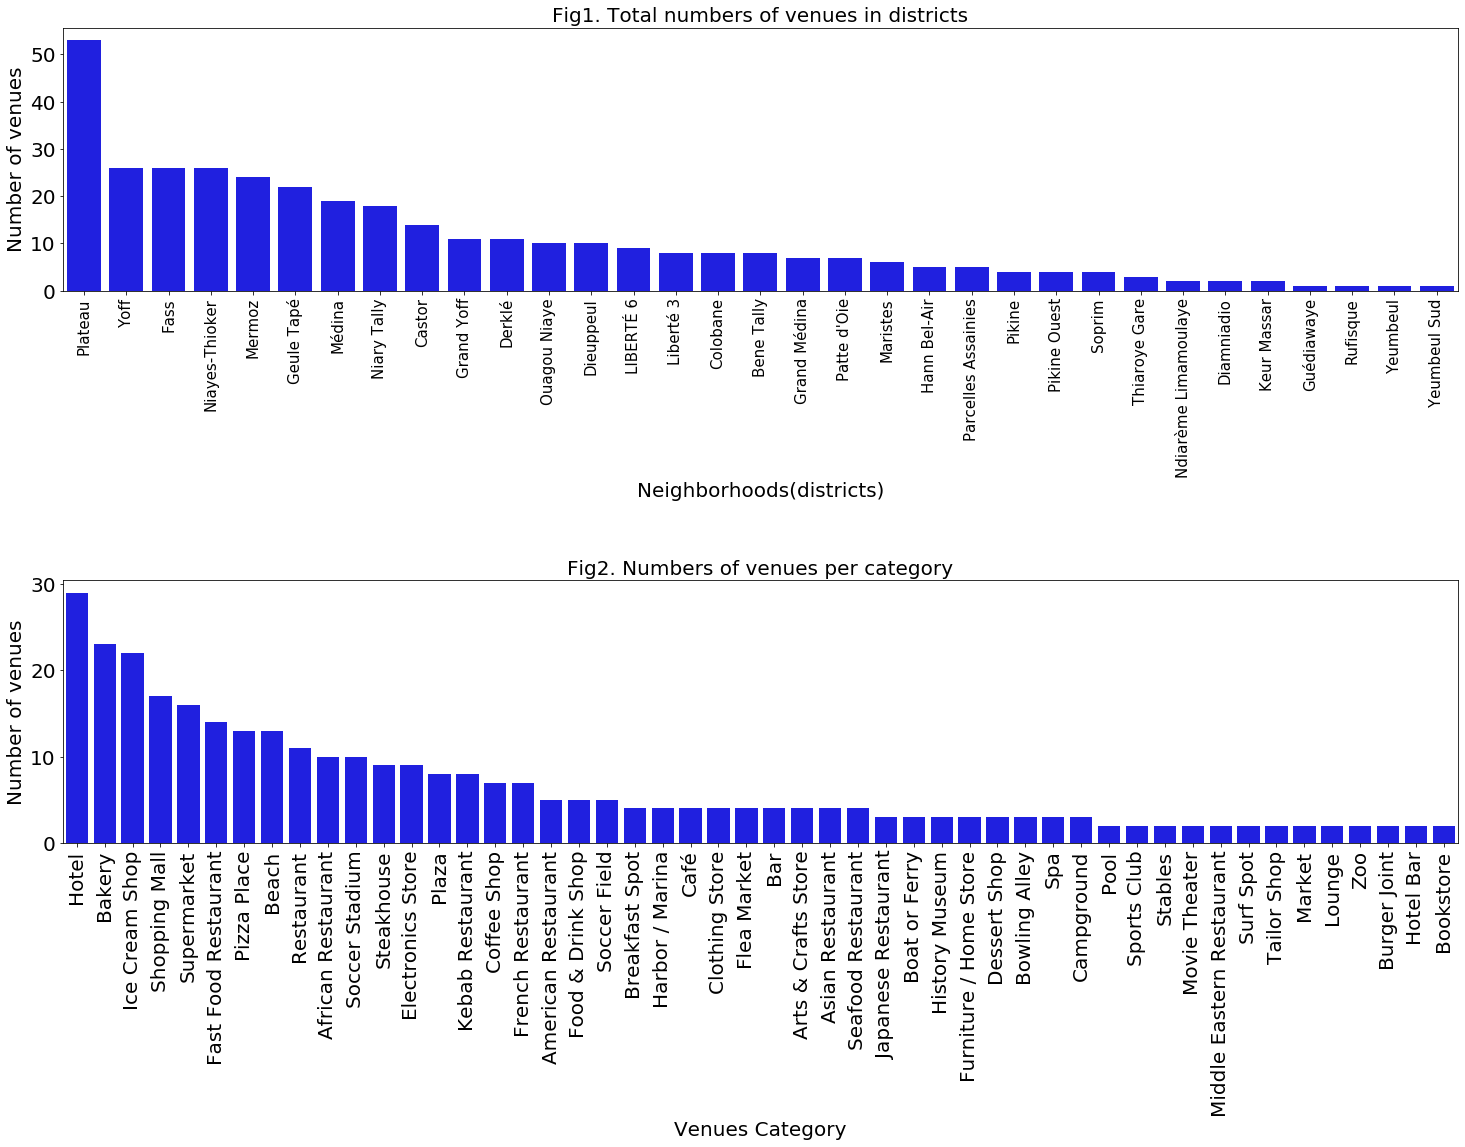

In [662]:
import seaborn as sns
from matplotlib import gridspec

f = plt.figure(figsize=(25, 15)) 
gs = gridspec.GridSpec( 2, 1,hspace=1.1) 
ax2 = plt.subplot(gs[0])
ax1= plt.subplot(gs[1])



sns.barplot(x="Venue Category", y="Venue",color='blue' ,data=venues_cat.sort_values(by='Venue', ascending=False).head(50),ax=ax1)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax1.tick_params(axis='x', rotation=90)


sns.barplot(x="neighborhood", y="Venue",color='blue' ,data=venues_count.sort_values(by='Venue', ascending=False),ax=ax2)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ax2.tick_params(axis='x', rotation=90)


plt.xticks(rotation='vertical')
ax1.set(ylabel='Number of venues', xlabel='Venues Category')
ax2.set(ylabel='Number of venues', xlabel='Neighborhoods(districts)' )
ax1.title.set_text('Fig2. Numbers of venues per category')
ax2.title.set_text('Fig1. Total numbers of venues in districts')
ax1.title.set_size(20)
ax2.title.set_size(20)



plt.show()

### Let's create a map of the venues centered in Dakar.

In [663]:
# create map
map_dakar = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dakar_venues['Venue Latitude'], dakar_venues['Venue Longitude'], dakar_venues['Venue'], dakar_venues['neighborhood']):
    label = '{}, {}'.format(borough,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dakar)  
    
map_dakar

# 3- Clustering COVID infected sites and nearby venues.

No handles with labels found to put in legend.


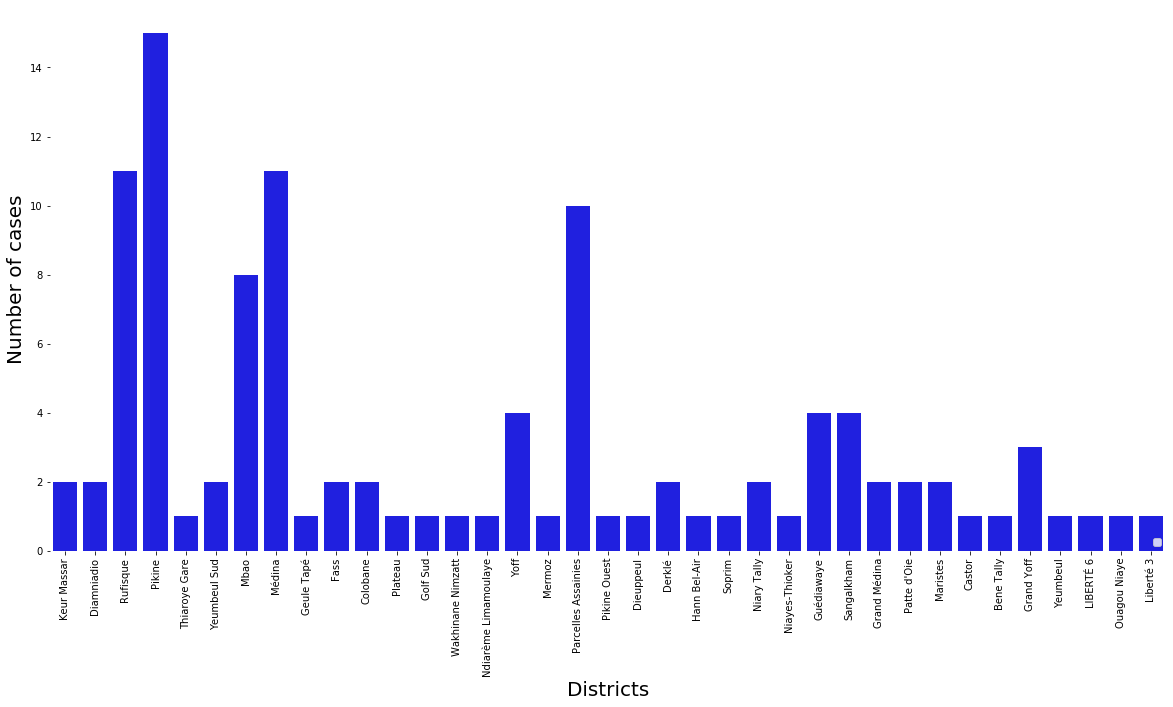

In [664]:
import seaborn as sns

f, ax = plt.subplots(figsize = (20,10))
sns.barplot(x="neighborhood", y="cas", color='blue',data=geo_cas_communautaire)
plt.xticks(rotation='vertical')

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.tick_params(axis='x', rotation=90)


ax.set(xlabel='Districts', ylabel='Number of cases')

ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()

In [665]:
#Select features cases,latitude and logitude
geo_cas_communautaire
geo_cas_communautaire1=geo_cas_communautaire[['cas','lat','lon']]

In [666]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(geo_cas_communautaire1)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

### Let's created a clustered map of  venues along with information on their contamination risk.

In [667]:
geo_cas_communautaire1.insert(0, 'Cluster Labels', kmeans.labels_)

In [668]:
geo_cas_communautaire1.head()

,Cluster Labels,cas,lat,lon
0,0,2,14.786388,-17.320696
1,0,2,14.720230,-17.184827
2,1,11,14.715560,-17.279684
3,1,15,14.755262,-17.404480
4,0,1,14.757339,-17.378268


In [669]:
geo_cas_communautaire3=geo_cas_communautaire1
geo_cas_communautaire3.insert(0, 'neighborhood',geo_cas_communautaire['neighborhood'].tolist() )
geo_cas_communautaire3.head()

,neighborhood,Cluster Labels,cas,lat,lon
0,Keur Massar,0,2,14.786388,-17.320696
1,Diamniadio,0,2,14.720230,-17.184827
2,Rufisque,1,11,14.715560,-17.279684
3,Pikine,1,15,14.755262,-17.404480
4,Thiaroye Gare,0,1,14.757339,-17.378268


We add cluster labels to geo_cas_communautaire Table.

In [670]:
result= geo_cas_communautaire[['departement','borough','neighborhood']].merge(geo_cas_communautaire1, how='outer', on='neighborhood')
result

,departement,borough,neighborhood,Cluster Labels,cas,lat,lon
0,Pikine,Niayes,Keur Massar,0,2,14.786388,-17.320696
1,Rufisque,Sangalkam,Diamniadio,0,2,14.720230,-17.184827
2,Rufisque,Rufisque,Rufisque,1,11,14.715560,-17.279684
3,Pikine,Dagoudane,Pikine,1,15,14.755262,-17.404480
4,Pikine,Thiaroye,Thiaroye Gare,0,1,14.757339,-17.378268
5,Pikine,Niayes,Yeumbeul Sud,0,2,14.772205,-17.366881
6,Pikine,Thiaroye,Mbao,1,8,14.729852,-17.330194
7,Dakar-Sud,Dakar-Plateau,Médina,1,11,14.682872,-17.454583
8,Dakar-Sud,Dakar-Plateau,Geule Tapé,0,1,14.682904,-17.459870
9,Dakar-Sud,Dakar-Plateau,Fass,0,2,14.690827,-17.457088


In [671]:
dakar_venues.shape

(358, 7)

 Merge::Add Cluster labels columns to Dakar venues table . Group labels by neighborhood.

In [672]:
dakar_venues_cluster =dakar_venues.merge(result[['neighborhood','Cluster Labels']], how='outer', on='neighborhood').dropna()
print(dakar_venues_cluster.shape)
dakar_venues_cluster.head()

(358, 8)


,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Keur Massar,14.786388,-17.320696,MTOA basketball ground,14.783254,-17.322969,Basketball Court,0
1,Keur Massar,14.786388,-17.320696,United Colors of Benetton,14.785432,-17.309188,Clothing Store,0
2,Diamniadio,14.720230,-17.184827,Tamou Fishing International,14.724417,-17.174485,Outlet Mall,0
3,Diamniadio,14.720230,-17.184827,Atlas Pave Tech +,14.712836,-17.195394,Factory,0
4,Rufisque,14.715560,-17.279684,Brioche dorée,14.717900,-17.284400,Fast Food Restaurant,1


We can define clusters as below : Cluster 0 : “Low Level Risk”, Cluster 1 : “High Level Risk”, Cluster 2: “Moderate Risk”
Let's add the attribute Level  to the below dataframe.

In [673]:
def func(row):
    if row['Cluster Labels'] == 0 :
        return 'Low'
    elif row['Cluster Labels'] ==1:
        return 'High' 
    else:
        return 'Moderate'

dakar_venues_cluster['Level_labels'] = dakar_venues_cluster.apply(func, axis=1)

In [674]:
dakar_venues_cluster.rename(columns={'neighborhood': 'Neighborhood'}, inplace=True)

In [675]:
dakar_venues_cluster[0:160]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Level_labels
0,Keur Massar,14.786388,-17.320696,MTOA basketball ground,14.783254,-17.322969,Basketball Court,0,Low
1,Keur Massar,14.786388,-17.320696,United Colors of Benetton,14.785432,-17.309188,Clothing Store,0,Low
2,Diamniadio,14.720230,-17.184827,Tamou Fishing International,14.724417,-17.174485,Outlet Mall,0,Low
3,Diamniadio,14.720230,-17.184827,Atlas Pave Tech +,14.712836,-17.195394,Factory,0,Low
4,Rufisque,14.715560,-17.279684,Brioche dorée,14.717900,-17.284400,Fast Food Restaurant,1,High
...,...,...,...,...,...,...,...,...,...
155,Yoff,14.746007,-17.495102,La madrague,14.750053,-17.510458,Steakhouse,2,Moderate
156,Yoff,14.746007,-17.495102,Salon Prestige,14.745503,-17.490287,Airport Lounge,2,Moderate
157,Yoff,14.746007,-17.495102,Teranga Lounge,14.745474,-17.490244,Airport Lounge,2,Moderate
158,Yoff,14.746007,-17.495102,La Gondole,14.736943,-17.508980,Ice Cream Shop,2,Moderate


In [676]:
# set color scheme for the clusters

#high,moderate,low (1,2,0)

rainbow= ['black' , 'red','orange' ]
#rainbow= ['red' , 'orange','blue' ]
rainbow= ['red' ,'orange' ,'green']
# add markers to the map
mp__clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
markers_colors = []
for lat, lon, poi, cluster ,level,cat, ngh in zip(dakar_venues_cluster['Venue Latitude'], dakar_venues_cluster['Venue Longitude'], dakar_venues_cluster['Venue'],dakar_venues_cluster['Cluster Labels'], dakar_venues_cluster['Level_labels'],dakar_venues_cluster['Venue Category'],dakar_venues_cluster['Neighborhood']):
    label = folium.Popup(str(poi) +','+str(ngh)+ ', ' + str(level)+' risk,'+str(cat), parse_html=True)
    folium.Marker(
        [lat, lon],
        #radius=10,
        popup=label,
        #color=rainbow[cluster-1],
        icon=folium.Icon(color='white',icon_color=rainbow[cluster-1], icon='flag')
        #fill=True,
        #fill_color=rainbow[cluster-1],
        #fill_opacity=0.9
    ).add_to(mp__clusters)

mp__clusters.save(outfile= "map_clusters_2000.html")
mp__clusters